In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from scipy.sparse import csr_matrix, dok_matrix
from scipy.sparse.linalg import svds

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, max_error, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef

# Using PCA with the *train.csv* dataset and *unique_m.csv*

In [3]:
df = pd.read_csv("unique_m.csv")
df.shape

(21263, 88)

In [4]:
df.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [5]:
X = df.drop(columns=["critical_temp", "material"])
y = df.critical_temp

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

## Objective 1 - Dimensionality Reduction

In [7]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [8]:
pca = PCA(n_components=0.9, svd_solver="full").fit(X_train)
pca_scaled = PCA(n_components=0.9, svd_solver="full").fit(X_train_scaled)

In [9]:
len(pca.explained_variance_), len(pca_scaled.explained_variance_)

(17, 59)

- If the data is scaled, the number of components to represent 90% of the data is -----> **12**
- If the data is not scaled, the number of components to represent 90% of the data is --> **2**

In [10]:
X_train_reduced = pca.transform(X_train)
X_train_scaled_reduced = pca_scaled.transform(X_train_scaled)

In [11]:
def plot(x, y, c, ax, xlabel="", ylabel="", title=""):
    ax.scatter(x,y,c=c)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

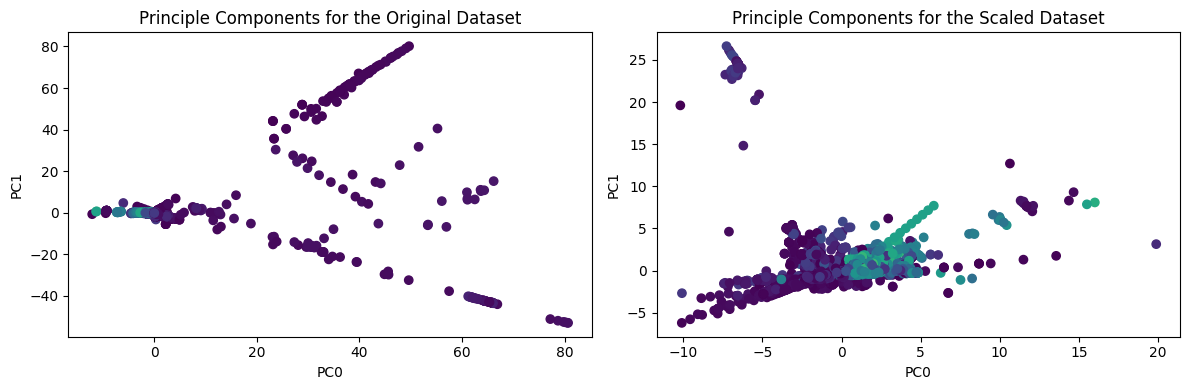

In [12]:
f, ax = plt.subplots(1,2, figsize=(12,4))

plot(X_train_reduced[:,0], X_train_reduced[:, 1], y_train, ax[0], "PC0", "PC1", "Principle Components for the Original Dataset")
plot(X_train_scaled_reduced[:,0], X_train_scaled_reduced[:, 1], y_train, ax[1], "PC0", "PC1", "Principle Components for the Scaled Dataset")
f.tight_layout()

We can observe that, even with more components for the 90% explainability, the data has a more clear separation when the data is scaled

## Objective 2 - Create a Regression and Classification model

### 2.1. Make a regression model

In [13]:
def evaluate(y_test, preds):
    print("RMSE =", mean_squared_error(y_test, preds, squared=False))
    print("Max. Error =", max_error(y_test, preds))
    
    plt.scatter(preds, y_test)
    plt.xlabel("Predictions")
    plt.ylabel("True Value")
    
    plt.plot(
        [ 0, 140], [0,140], "r"
    )

#### Using Full DataSet

Decision Tree seems to be a wise choice, since the data is decorrelated with PCA

In [14]:
dtr = DecisionTreeRegressor().fit(X_train, y_train)
dtr_scaled = DecisionTreeRegressor().fit(X_train_scaled, y_train)

In [15]:
preds = dtr.predict(X_test)
preds_scaled = dtr_scaled.predict(scaler.transform(X_test))

RMSE = 11.445087681907683
Max. Error = 105.5


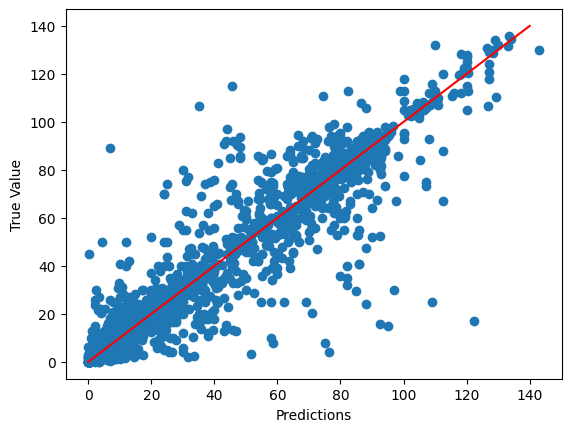

In [16]:
evaluate(y_test, preds)

RMSE = 11.730655443198012
Max. Error = 105.5


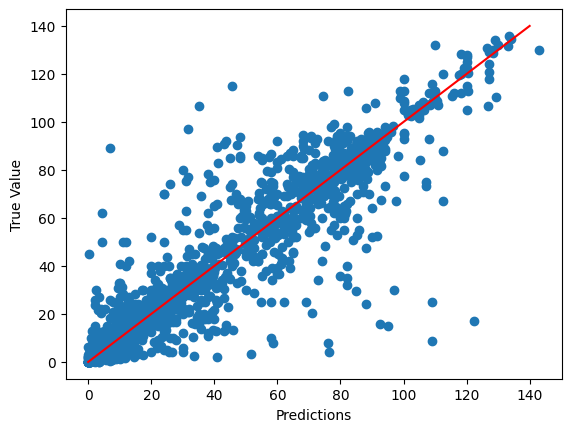

In [17]:
evaluate(y_test, preds_scaled)

#### Using Projected DataSet


In [18]:
dtr = Pipeline([
    ("reducter", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", DecisionTreeRegressor())
]).fit(X_train, y_train)
dtr_scaled = Pipeline([
    ("reducter", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", DecisionTreeRegressor())
]).fit(X_train_scaled, y_train)

In [19]:
preds = dtr.predict(X_test)
preds_scaled = dtr_scaled.predict(scaler.transform(X_test))

RMSE = 12.792919790354139
Max. Error = 108.0


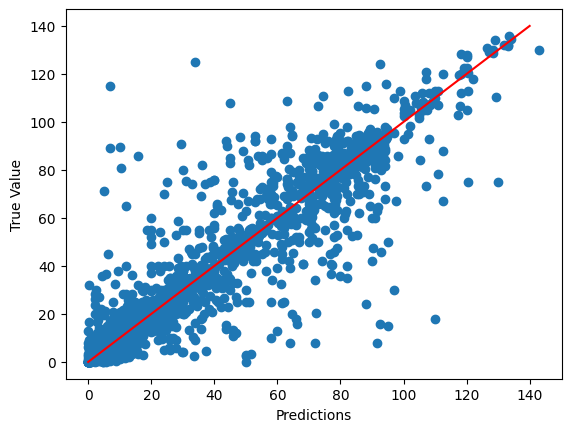

In [20]:
evaluate(y_test, preds)

RMSE = 12.788445467564795
Max. Error = 97.48666666666666


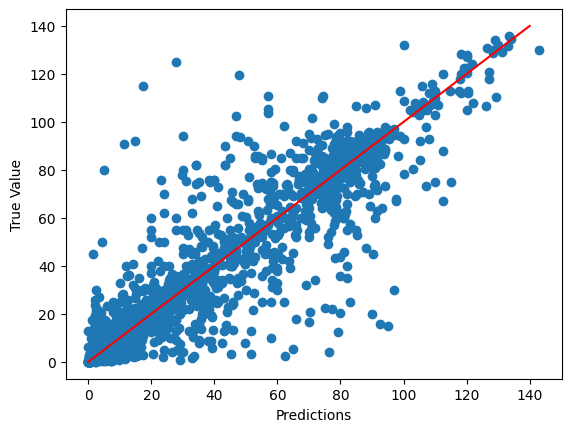

In [21]:
evaluate(y_test, preds_scaled)

### 2.2 Make a Classification Model

In [115]:
def to_class(x: float) -> str:
    if 0 <= x < 1.0:
        return "VeryLow"
    elif 1 <= x < 5.0:
        return "Low"
    elif 5 <= x < 20.0:
        return "Medium"
    elif 20 <= x < 100.0:
        return "High"
    elif x >= 100:
        return "VeryHigh"
    return None

In [116]:
y_train_class = y_train.apply(lambda x: to_class(x))
y_test_class = y_test.apply(lambda x: to_class(x))

In [117]:
def cat_evaluate(y_test, preds):
    print("MCC =", matthews_corrcoef(y_test, preds))
    
    ConfusionMatrixDisplay(
        confusion_matrix(y_test, preds)
    ).plot()

#### Using Full Dataset

##### Naive Bayes

In [35]:
(X_train_scaled==0).sum()/np.prod(X_train_scaled.shape)

0.10465116279069768

In [34]:
(X_train.to_numpy()==0).sum()/np.prod(X_train.shape)

0.9521235999844443

In [46]:
nb = GaussianNB().fit(X_train, y_train_class)
nb_scaled = GaussianNB().fit(X_train_scaled, y_train_class)

In [47]:
preds = nb.predict(X_test)
preds_scaled = nb_scaled.predict(scaler.transform(X_test))

MCC = 0.20031503639073892


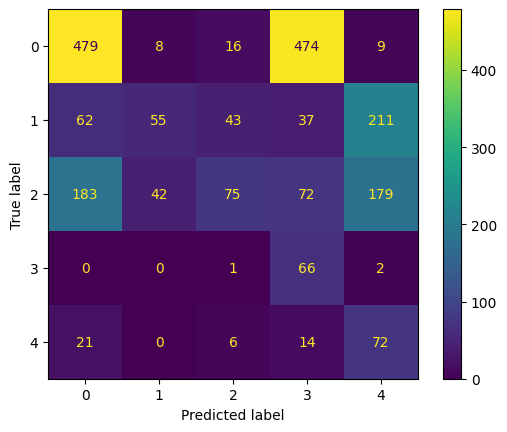

In [48]:
cat_evaluate(y_test_class, preds)

MCC = 0.19736193991130463


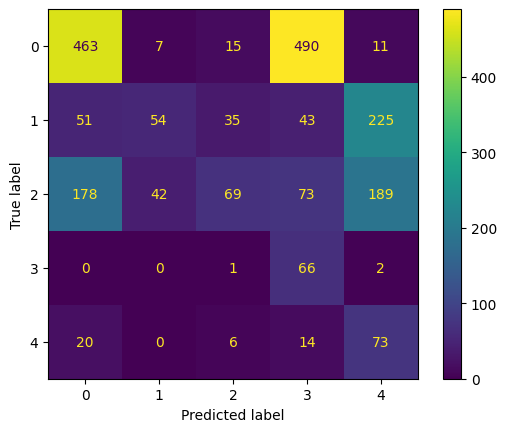

In [49]:
cat_evaluate(y_test_class, preds_scaled)

##### Decision Tree

In [86]:
dtc = DecisionTreeClassifier().fit(X_train, y_train_class)
dtc_scaled = DecisionTreeClassifier().fit(X_train_scaled, y_train_class)

In [87]:
preds = dtc.predict(X_test)
preds_scaled = dtc_scaled.predict(scaler.transform(X_test))

MCC = 0.7670971881247528


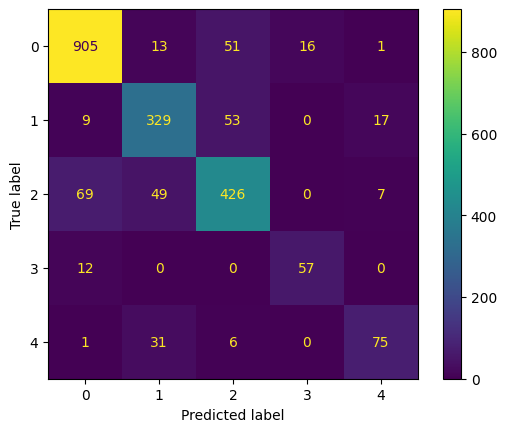

In [88]:
cat_evaluate(y_test_class, preds)

MCC = 0.7695116483918447


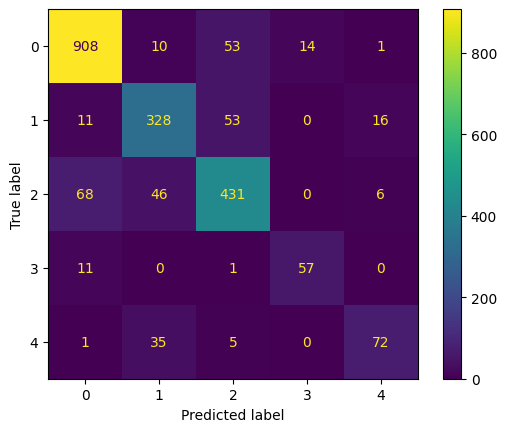

In [89]:
cat_evaluate(y_test_class, preds_scaled)

#### Using Projected Dataset

##### Naive Bayes

In [82]:
nb = Pipeline([
    ("reductor", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", GaussianNB())
]).fit(X_train, y_train_class)
nb_scaled = Pipeline([
    ("reductor", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", GaussianNB())
]).fit(X_train_scaled, y_train_class)

In [83]:
preds = nb.predict(X_test)
preds_scaled = nb_scaled.predict(scaler.transform(X_test))

MCC = 0.43681796116862837


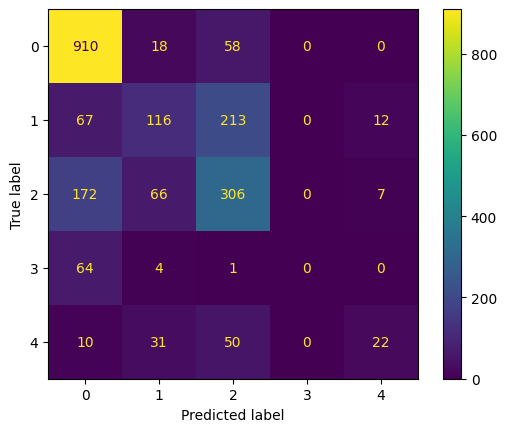

In [84]:
cat_evaluate(y_test_class, preds)

MCC = 0.46676141792511133


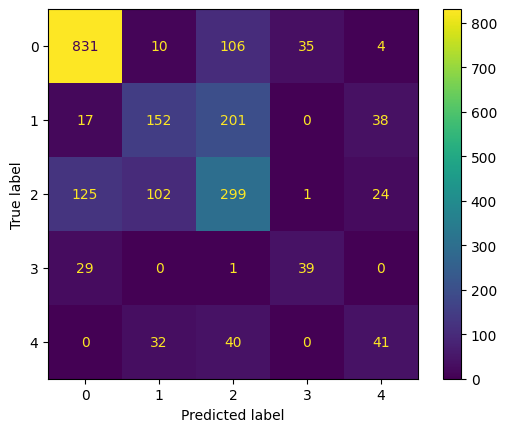

In [85]:
cat_evaluate(y_test_class, preds_scaled)

##### Decision Tree

In [90]:
dtc = Pipeline([
    ("reductor", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", DecisionTreeClassifier())
]).fit(X_train, y_train_class)
dtc_scaled = Pipeline([
    ("reductor", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", DecisionTreeClassifier())
]).fit(X_train_scaled, y_train_class)

In [91]:
preds = dtc.predict(X_test)
preds_scaled = dtc_scaled.predict(scaler.transform(X_test))

MCC = 0.6807797544127574


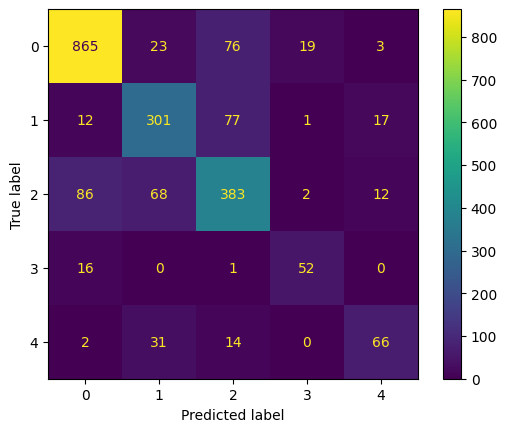

In [92]:
cat_evaluate(y_test_class, preds)

MCC = 0.7547508116617709


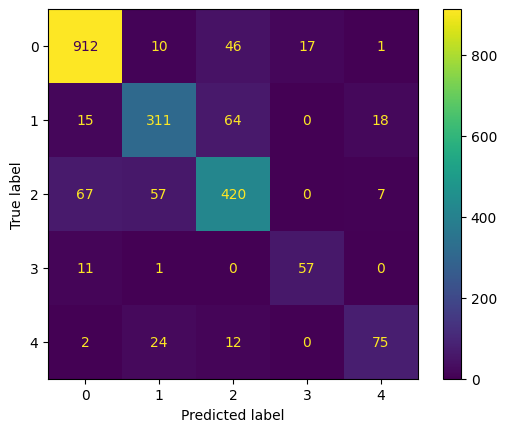

In [93]:
cat_evaluate(y_test_class, preds_scaled)

# Using SVD in the *unique_m.csv" Dataset

In [94]:
df = pd.read_csv("unique_m.csv")
df.shape

(21263, 88)

In [95]:
df.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [96]:
X = df.drop(columns=["critical_temp", "material"])
y = df.critical_temp

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

## Objective 1 - Dimensionality Reduction

In [118]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [119]:
def get_decomposition(x):
    s = np.linalg.svd(x, compute_uv=False)
    norm_s = (s**2)/(s**2).sum()
    N = (np.cumsum(norm_s)<0.9).sum()
    
    u,s,v = svds( csr_matrix(x), k=N+1 )
    return u,s,v

In [149]:
def get_test_decomposition(x, s, v):
    u_test = x @ v.T
    return u_test @ np.diag(s) @ v

In [120]:
u,s,v = get_decomposition(X_train)
u_scaled, s_scaled, v_scaled = get_decomposition(X_train_scaled)

In [121]:
u.shape[1], u_scaled.shape[1]

(16, 59)

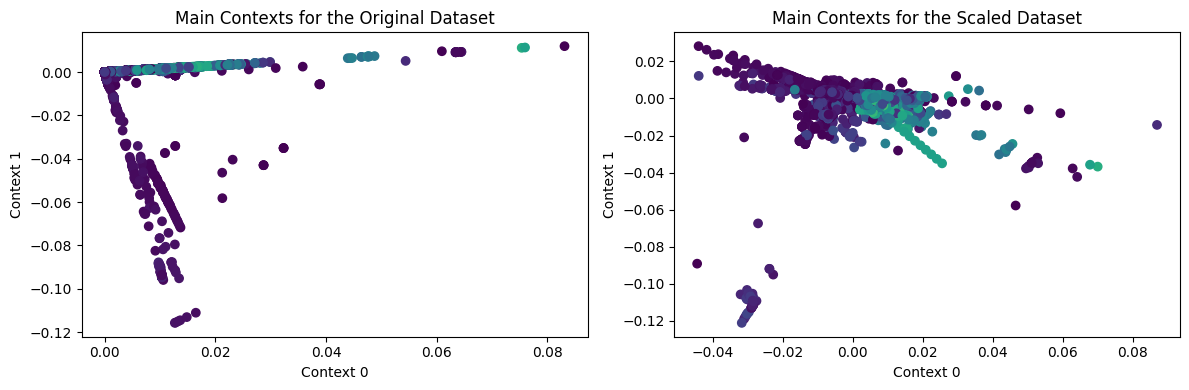

In [128]:
f, ax = plt.subplots(1,2, figsize=(12,4))

plot(u[:,-1], u[:, -2], y_train, ax[0], "Context 0", "Context 1", "Main Contexts for the Original Dataset")
plot(u_scaled[:, -1], u_scaled[:, -2], y_train, ax[1], "Context 0", "Context 1", "Main Contexts for the Scaled Dataset")
f.tight_layout()

- If the data is scaled, the number of contexts to represent 90% of the data is -----> **59**
- If the data is not scaled, the number of contexts to represent 90% of the data is --> **16**

## Objective 2 - Make a Regression and a Classification Model

### 2.1. Make a regression model

##### Using Full DataSet

In [67]:
dtr = DecisionTreeRegressor().fit(X_train, y_train)
dtr_scaled = DecisionTreeRegressor().fit(X_train_scaled, y_train)

In [68]:
preds = dtr.predict(X_test)
preds_scaled = dtr_scaled.predict(scaler.transform(X_test))

RMSE = 11.530236106028704
Max. Error = 105.5


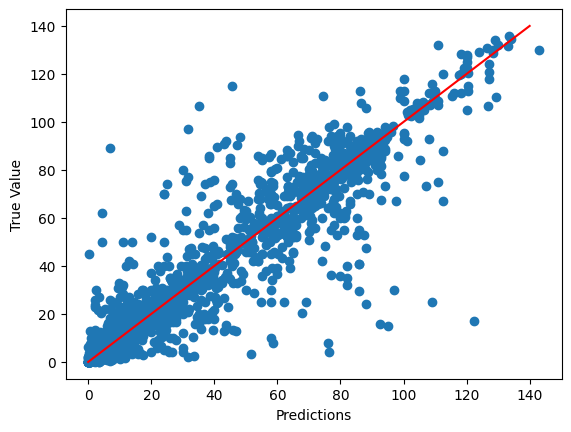

In [69]:
evaluate(y_test, preds)

RMSE = 11.25626151877632
Max. Error = 98.12


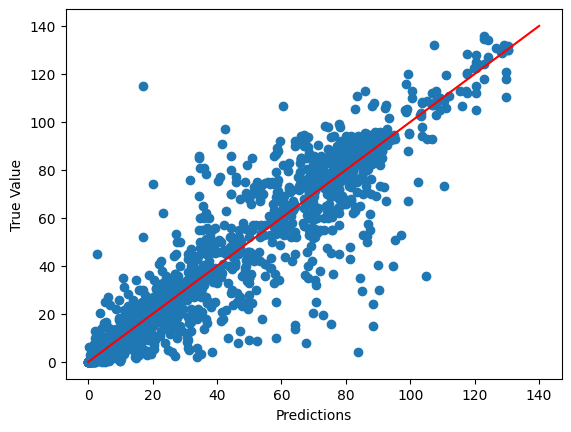

In [66]:
evaluate(y_test, preds_scaled)

#### Using Projected DataSet


In [144]:
dtr = DecisionTreeRegressor().fit(u @ np.diag(s) @ v, y_train)
dtr_scaled = DecisionTreeRegressor().fit(u_scaled @ np.diag(s_scaled) @ v_scaled, y_train)

In [164]:
dtr = DecisionTreeRegressor().fit(u, y_train)
dtr_scaled = DecisionTreeRegressor().fit(u_scaled, y_train)

In [150]:
preds = dtr.predict( get_test_decomposition(X_test, s, v) )
preds_scaled = dtr_scaled.predict( get_test_decomposition( scaler.transform(X_test), s, v) )

In [165]:
preds = dtr.predict( X_test @ v.T )
preds_scaled = dtr_scaled.predict( scaler.transform(X_test) @ v_scaled.T )

RMSE = 41.31262213921804
Max. Error = 126.46


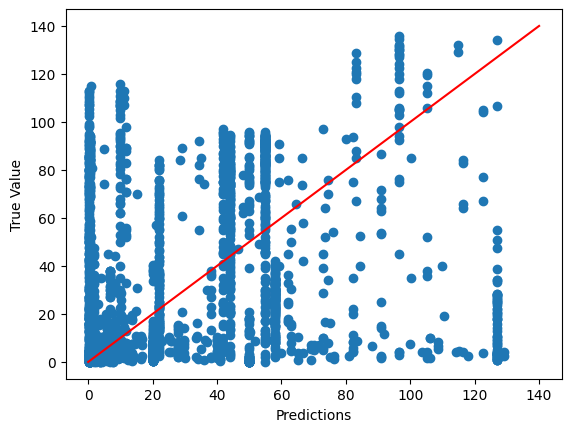

In [168]:
evaluate(y_test, preds)

RMSE = 37.508739490140194
Max. Error = 120.4


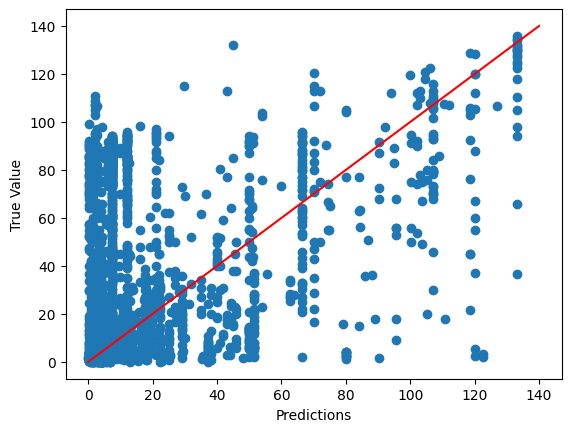

In [169]:
evaluate(y_test, preds_scaled)

### 2.2. Make a classification model

#### Using Full Dataset

##### Naive Bayes

In [198]:
nb = GaussianNB().fit(X_train, y_train_class)
nb_scaled = GaussianNB().fit(X_train_scaled, y_train_class)

In [199]:
preds = nb.predict(X_test)
preds_scaled = nb_scaled.predict(scaler.transform(X_test))

MCC = 0.20031503639073892


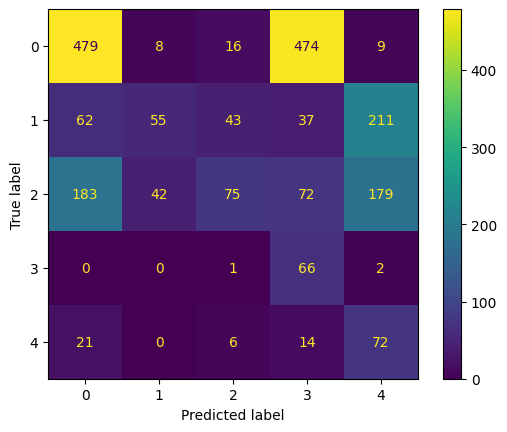

In [200]:
cat_evaluate(y_test_class, preds)

MCC = 0.19736193991130463


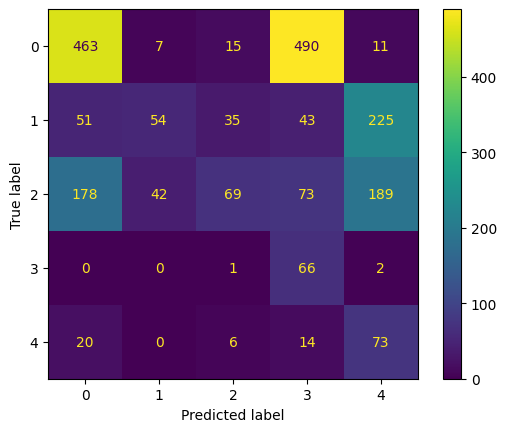

In [193]:
cat_evaluate(y_test_class, preds_scaled)

##### Decision Tree

In [201]:
dtc = DecisionTreeClassifier().fit(X_train, y_train_class)
dtc_scaled = DecisionTreeClassifier().fit(X_train_scaled, y_train_class)

In [202]:
preds = dtc.predict(X_test)
preds_scaled = dtc_scaled.predict(scaler.transform(X_test))

MCC = 0.7861577200569273


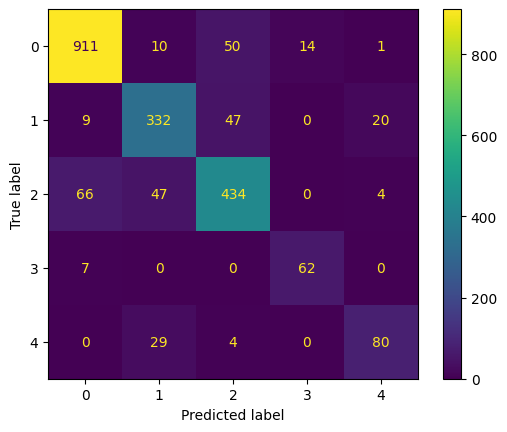

In [203]:
cat_evaluate(y_test_class, preds)

MCC = 0.7862467275496705


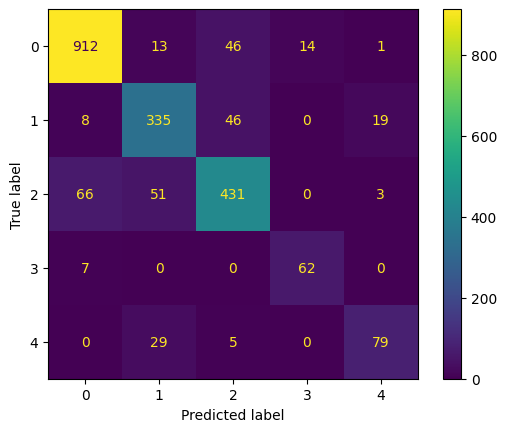

In [204]:
cat_evaluate(y_test_class, preds_scaled)

#### Using Projected Dataset

##### Naive Bayes

In [211]:
nb = GaussianNB().fit(u @ np.diag(s) @ v, y_train_class)
nb_scaled = GaussianNB().fit(u_scaled @ np.diag(s_scaled) @ v_scaled, y_train_class)

In [212]:
preds = nb.predict(X_test @ v.T @ np.diag(s) @ v)
preds_scaled = nb_scaled.predict(scaler.transform(X_test) @ v_scaled.T @ np.diag(s_scaled) @ v_scaled)

MCC = 0.17201264197756655


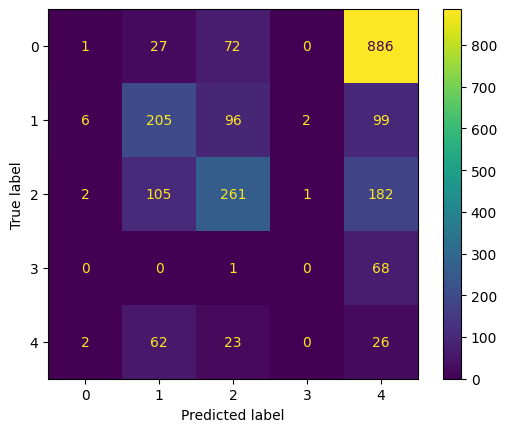

In [213]:
cat_evaluate(y_test_class, preds)

MCC = 0.1093671616705808


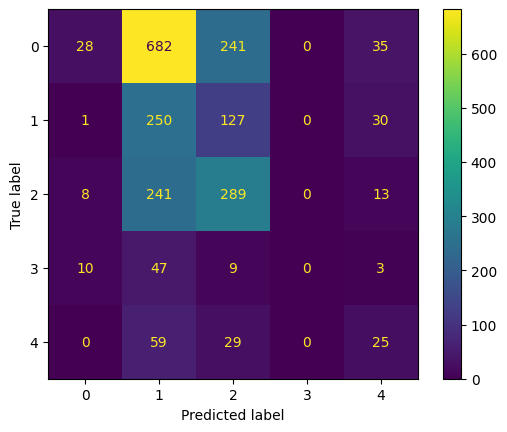

In [214]:
cat_evaluate(y_test_class, preds_scaled)

##### Decision Tree

In [219]:
dtc = DecisionTreeClassifier().fit(u, y_train_class)
dtc_scaled = DecisionTreeClassifier().fit(u_scaled, y_train_class)

In [220]:
preds = dtc.predict(X_test @ v.T)
preds_scaled = dtc_scaled.predict(scaler.transform(X_test) @ v_scaled.T )

MCC = 0.06015344985664099


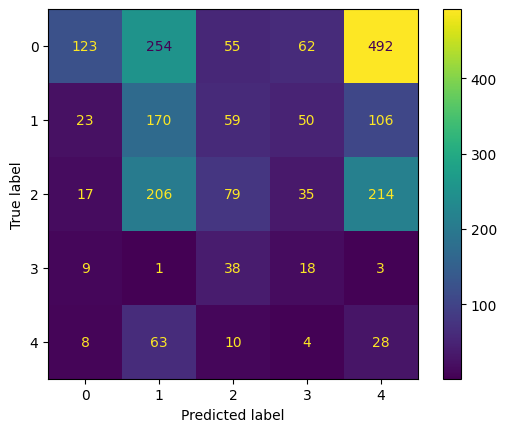

In [221]:
cat_evaluate(y_test_class, preds)

MCC = 0.05457258404255577


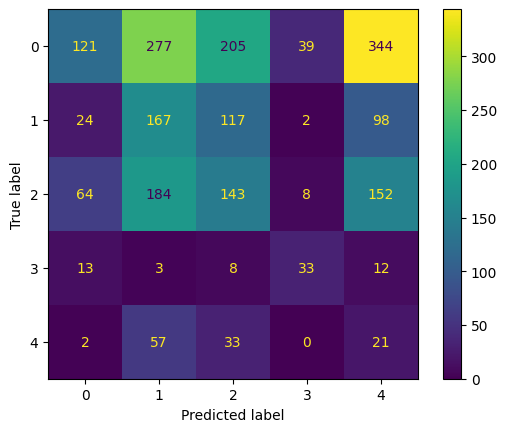

In [222]:
cat_evaluate(y_test_class, preds_scaled)

# Using Both Datasets

In [82]:
df = pd.read_csv("train.csv").merge(
    pd.read_csv("unique_m.csv"), 
    left_index=True, 
    right_index=True
)
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp_y,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [83]:
(df.to_numpy()==0).sum() / np.prod(df.shape)

0.4864401293603083

In [85]:
X = df.drop(columns=["critical_temp_y", "critical_temp_x", "material"])
y = df.critical_temp_x

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

## Objective 1 - Dimensionality Reduction

### PCA

In [103]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

pca = PCA(n_components=0.9, svd_solver="full").fit(X_train)
pca_scaled = PCA(n_components=0.9, svd_solver="full").fit(X_train_scaled)

len(pca.explained_variance_), len(pca_scaled.explained_variance_)

(2, 66)

- If the data is scaled, the number of components to represent 90% of the data is -----> **66**
- If the data is not scaled, the number of components to represent 90% of the data is --> **2**

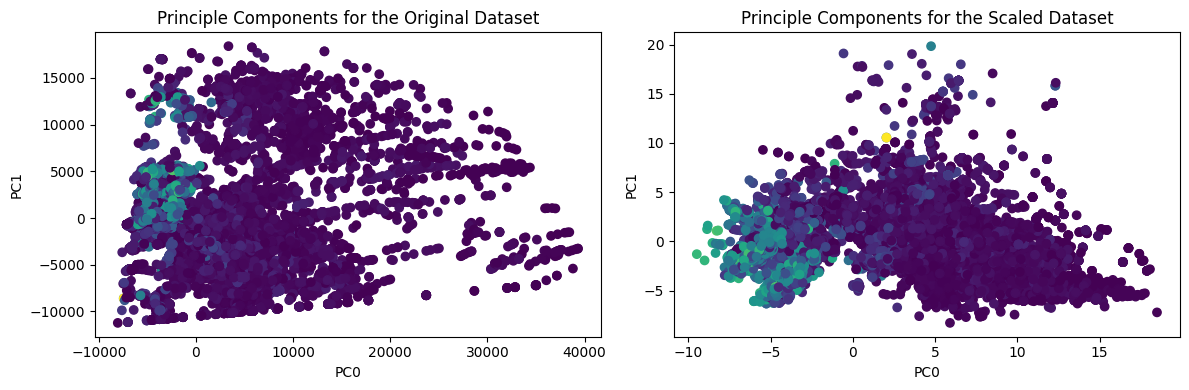

In [105]:
X_train_reduced = pca.transform(X_train)
X_train_scaled_reduced = pca_scaled.transform(X_train_scaled)

def plot(x, y, c, ax, xlabel="", ylabel="", title=""):
    ax.scatter(x,y,c=c)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
f, ax = plt.subplots(1,2, figsize=(12,4))

plot(X_train_reduced[:,0], X_train_reduced[:, 1], y_train, ax[0], "PC0", "PC1", "Principle Components for the Original Dataset")
plot(X_train_scaled_reduced[:,0], X_train_scaled_reduced[:, 1], y_train, ax[1], "PC0", "PC1", "Principle Components for the Scaled Dataset")
f.tight_layout()

### SVD

In [90]:
def get_decomposition(x):
    s = np.linalg.svd(x, compute_uv=False)
    norm_s = (s**2)/(s**2).sum()
    N = (np.cumsum(norm_s)<0.9).sum()
    
    u,s,v = svds( csr_matrix(x), k=N+1 )
    return u,s,v

In [91]:
def get_test_decomposition(x, s, v):
    u_test = x @ v.T
    return u_test @ np.diag(s) @ v

In [92]:
u,s,v = get_decomposition(X_train)
u_scaled, s_scaled, v_scaled = get_decomposition(X_train_scaled)

In [93]:
u.shape[1], u_scaled.shape[1] 

(2, 66)

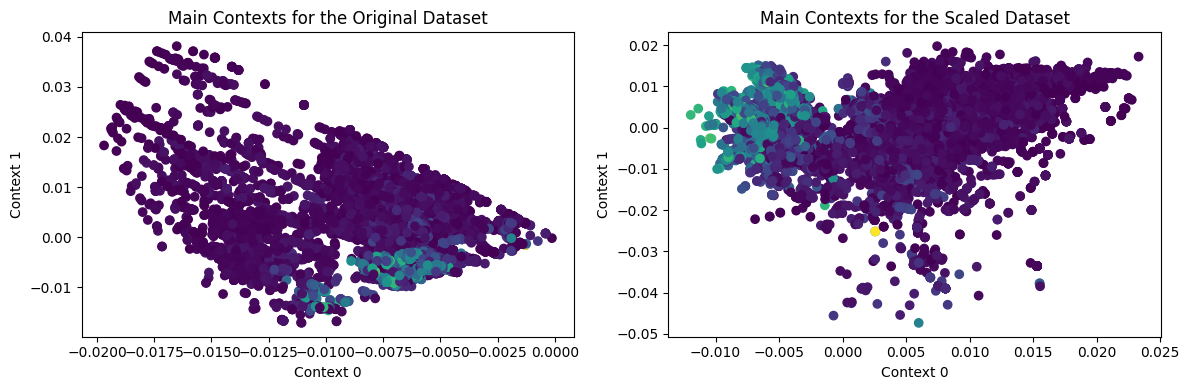

In [100]:
f, ax = plt.subplots(1,2, figsize=(12,4))

plot(u[:,-1], u[:, -2], y_train, ax[0], "Context 0", "Context 1", "Main Contexts for the Original Dataset")
plot(u_scaled[:, -1], u_scaled[:, -2], y_train, ax[1], "Context 0", "Context 1", "Main Contexts for the Scaled Dataset")
f.tight_layout()

## Objective 2 - Create a Regression and Classification model

### 2.1. Make a regression model

#### PCA

RMSE = 12.869083008674785
Max. Error = 119.62


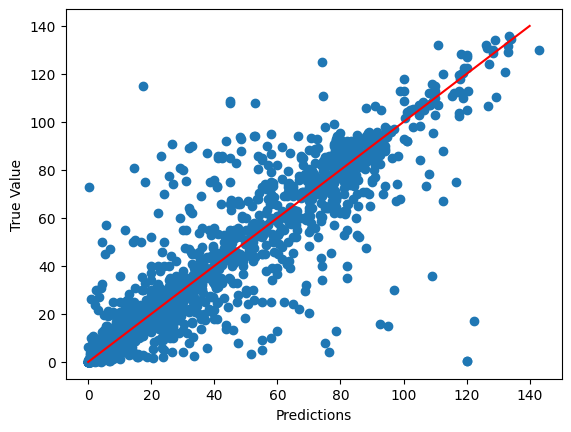

In [111]:
dtr = DecisionTreeRegressor().fit(X_train, y_train)
dtr_scaled = DecisionTreeRegressor().fit(X_train_scaled, y_train)

preds = dtr.predict(X_test)
preds_scaled = dtr_scaled.predict(scaler.transform(X_test))

evaluate(y_test, preds)

RMSE = 12.16514376445823
Max. Error = 105.5


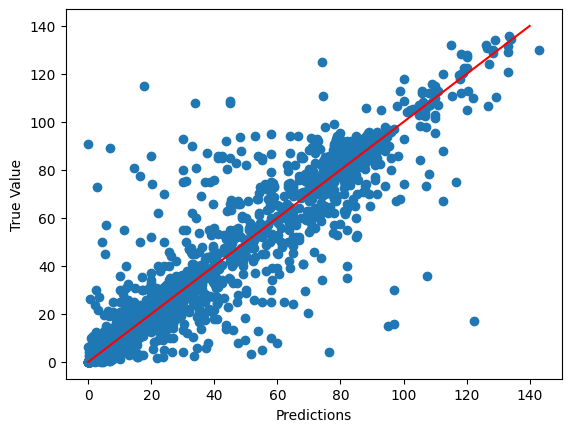

In [112]:
evaluate(y_test, preds_scaled)

RMSE = 17.988808241891167
Max. Error = 117.44999999999999


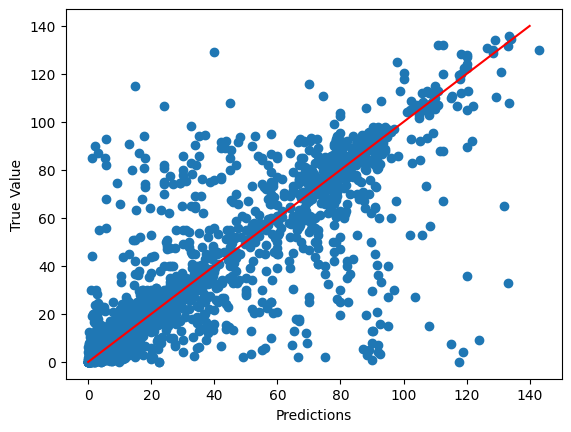

In [113]:
dtr = Pipeline([
    ("reducter", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", DecisionTreeRegressor())
]).fit(X_train, y_train)
dtr_scaled = Pipeline([
    ("reducter", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", DecisionTreeRegressor())
]).fit(X_train_scaled, y_train)

preds = dtr.predict(X_test)
preds_scaled = dtr_scaled.predict(scaler.transform(X_test))

evaluate(y_test, preds)

RMSE = 12.751917514940407
Max. Error = 129.8


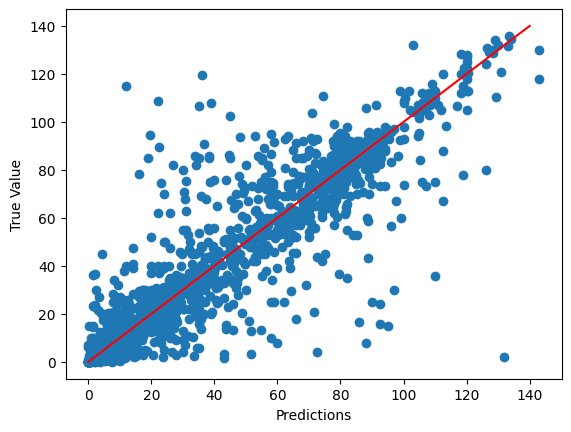

In [114]:
evaluate(y_test, preds_scaled)

#### SVD

RMSE = 44.03078380141812
Max. Error = 129.8


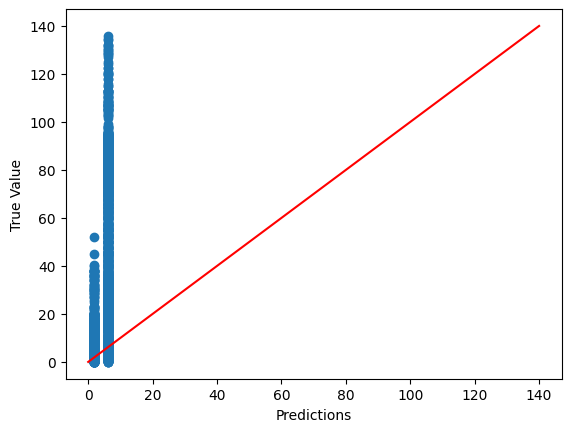

In [138]:
dtr = DecisionTreeRegressor().fit(u, y_train)
dtr_scaled = DecisionTreeRegressor().fit(u_scaled, y_train)

preds = dtr.predict( X_test @ v.T )
preds_scaled = dtr_scaled.predict(scaler.transform(X_test) @ v_scaled.T)

evaluate(y_test, preds)

RMSE = 36.961253148428206
Max. Error = 115.2


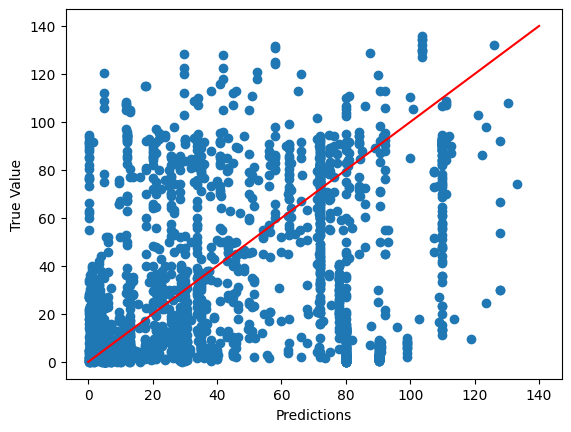

In [139]:
evaluate(y_test, preds_scaled)

### 2.2 Make a Classification Model

MCC = 0.3505549692609269


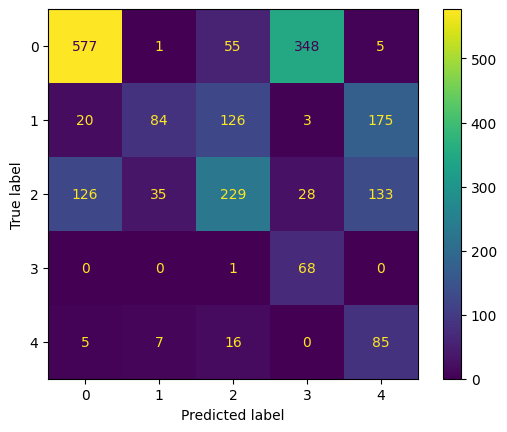

In [142]:
nb = GaussianNB().fit(X_train, y_train_class)
nb_scaled = GaussianNB().fit(X_train_scaled, y_train_class)

preds = nb.predict(X_test)
preds_scaled = nb_scaled.predict(scaler.transform(X_test))

cat_evaluate(y_test_class, preds)

MCC = 0.24346245202512415


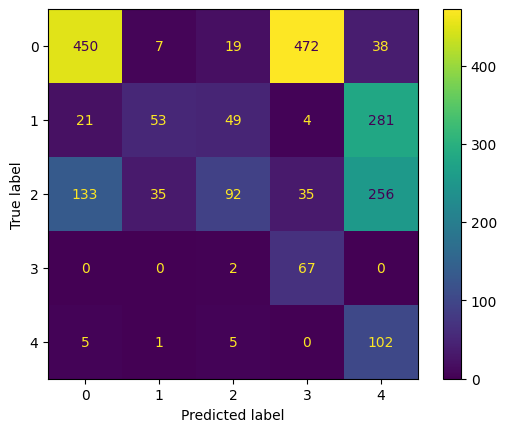

In [143]:
cat_evaluate(y_test_class, preds_scaled)

MCC = 0.774385857766281


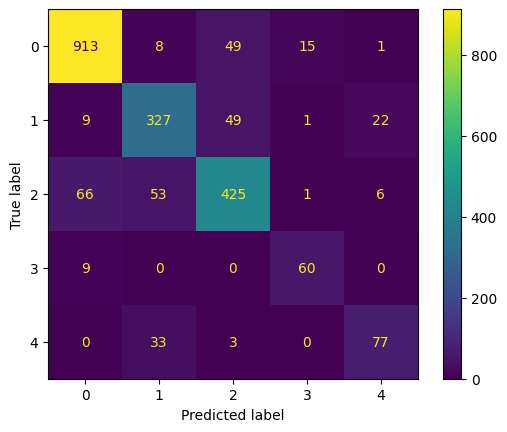

In [145]:
dtc = DecisionTreeClassifier().fit(X_train, y_train_class)
dtc_scaled = DecisionTreeClassifier().fit(X_train_scaled, y_train_class)

preds = dtc.predict(X_test)
preds_scaled = dtc_scaled.predict(scaler.transform(X_test))

cat_evaluate(y_test_class, preds)

MCC = 0.7677108679875332


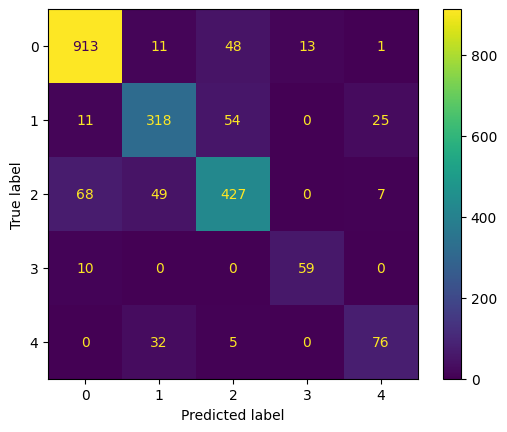

In [146]:
cat_evaluate(y_test_class, preds_scaled)

MCC = 0.43681796116862837


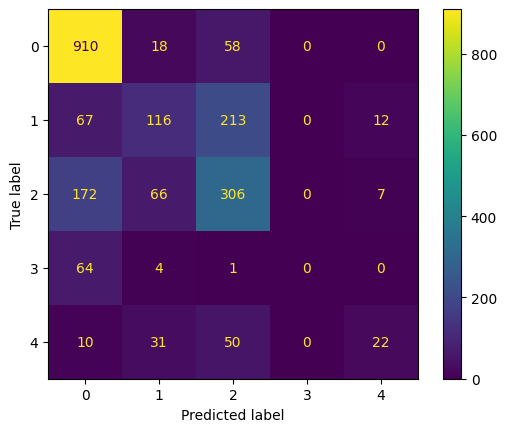

In [147]:
nb = Pipeline([
    ("reducter", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", GaussianNB())
]).fit(X_train, y_train_class)
nb_scaled = Pipeline([
    ("reducter", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", GaussianNB())
]).fit(X_train_scaled, y_train_class)

preds = nb.predict(X_test)
preds_scaled = nb_scaled.predict(scaler.transform(X_test))

cat_evaluate(y_test_class, preds)

MCC = 0.16762966603788532


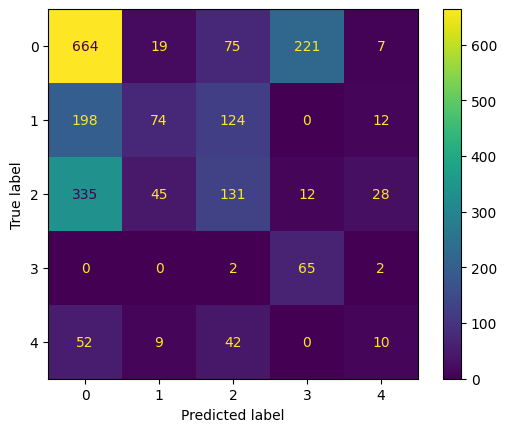

In [148]:
cat_evaluate(y_test_class, preds_scaled)

MCC = 0.6906987555180477


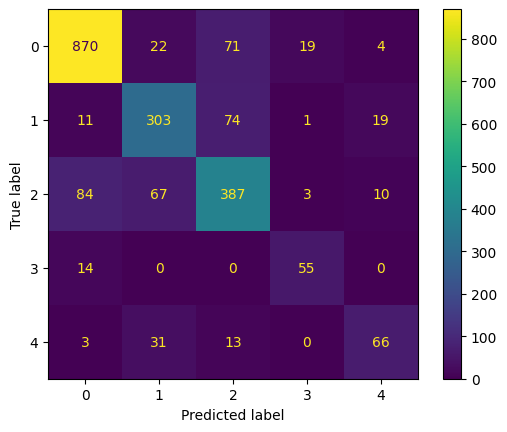

In [149]:
nb = Pipeline([
    ("reducter", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", DecisionTreeClassifier())
]).fit(X_train, y_train_class)
nb_scaled = Pipeline([
    ("reducter", PCA(n_components=0.9, svd_solver="full")),
    ("predictor", DecisionTreeClassifier())
]).fit(X_train_scaled, y_train_class)

preds = nb.predict(X_test)
preds_scaled = nb_scaled.predict(scaler.transform(X_test))

cat_evaluate(y_test_class, preds)

MCC = 0.7379005647272076


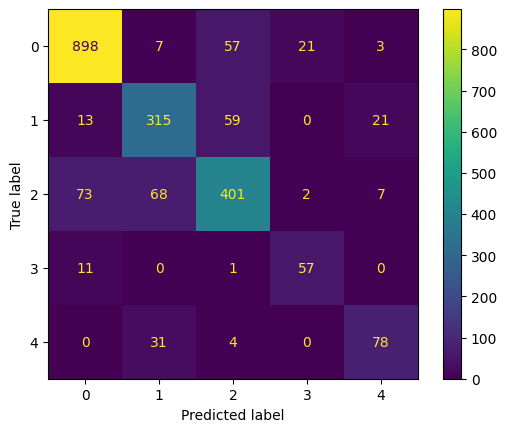

In [150]:
cat_evaluate(y_test_class, preds_scaled)

MCC = 0.0


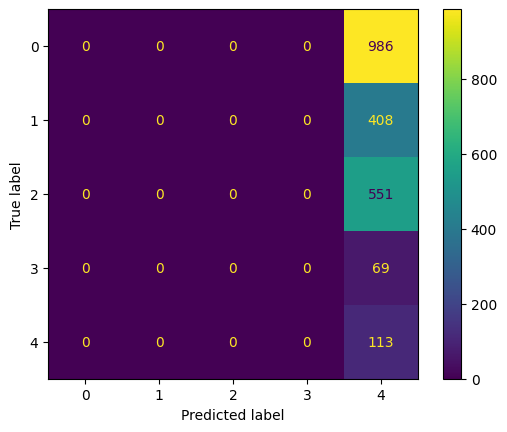

In [152]:
nb = GaussianNB().fit(u, y_train_class)
nb_scaled = GaussianNB().fit(u_scaled, y_train_class)

preds = nb.predict( X_test @ v.T )
preds_scaled = nb_scaled.predict(scaler.transform(X_test) @ v_scaled.T)

cat_evaluate(y_test_class, preds)

MCC = -0.01669990793534828


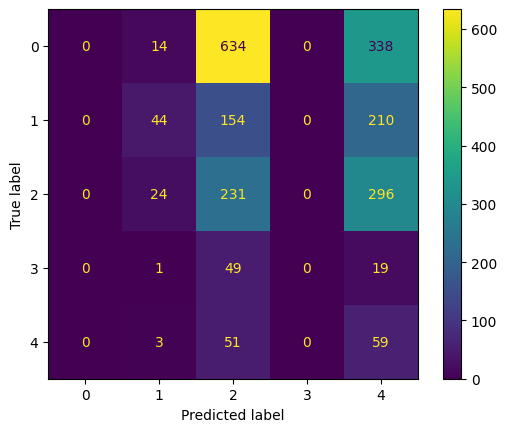

In [153]:
cat_evaluate(y_test_class, preds_scaled)

MCC = -0.06288735556577675


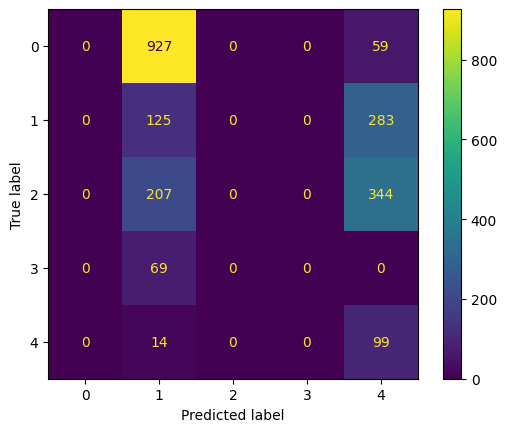

In [154]:
dtr = DecisionTreeClassifier().fit(u, y_train_class)
dtr_scaled = DecisionTreeClassifier().fit(u_scaled, y_train_class)

preds = dtr.predict( X_test @ v.T )
preds_scaled = dtr_scaled.predict(scaler.transform(X_test) @ v_scaled.T)

cat_evaluate(y_test_class, preds)

MCC = 0.1608843372719521


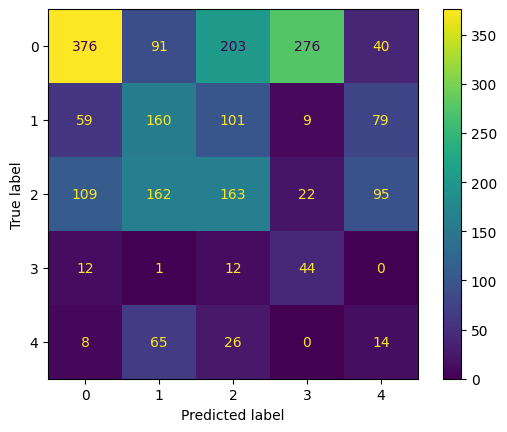

In [155]:
cat_evaluate(y_test_class, preds_scaled)